In [2]:
import matplotlib.pyplot as plt
from numpy import prod
import pandas as pd
import numpy as np
import cv2

In [3]:
def split_img(img, img_size=(40, 40)):
    imgs = []
    n_rows, n_cols = img.shape[0], img.shape[1]
    img_height = img_size[0]
    img_width = img_size[1]
    for row in range(img_height, n_rows, img_height):
        for col in range(img_width, n_cols, img_width):
            row_last = row - img_height
            col_last = col - img_width
            img_crop = img[row_last:row, col_last:col]
            imgs.append(img_crop)
    return np.array(imgs)

In [4]:
def vec2img(vec, img_size=(40, 40)):
    return vec.reshape(img_size)

def img2vec(img):
    return img.reshape((prod(img.shape)))

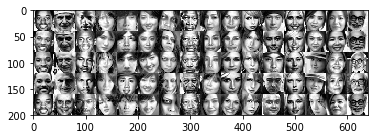

In [5]:
img = cv2.imread("data/facesP1.bmp", 0)
plt.imshow(img, cmap='gray')

In [7]:
imgs = split_img(img)
print(imgs.shape)

imgs = imgs.reshape( (prod(imgs.shape[:1]), prod(imgs.shape[1:])) ).T
print(imgs.shape)

(60, 40, 40)
(1600, 60)


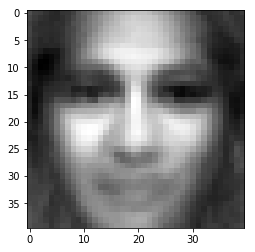

In [8]:
mean_vector = imgs.mean(1)

mean_face = vec2img(mean_vector)
plt.imshow(mean_face, cmap = 'gray'), plt.show()

diff_imgs = imgs - np.tile(np.array([mean_vector]).T, (1, 60))
T_trans_T = np.cov(diff_imgs.T)

In [35]:
print(imgs.shape)
print(np.tile(np.array([mean_vector]).T, (1, 60)))

(1600, 60)
[[108.08333333 108.08333333 108.08333333 ... 108.08333333 108.08333333
  108.08333333]
 [ 98.11666667  98.11666667  98.11666667 ...  98.11666667  98.11666667
   98.11666667]
 [ 97.18333333  97.18333333  97.18333333 ...  97.18333333  97.18333333
   97.18333333]
 ...
 [ 95.68333333  95.68333333  95.68333333 ...  95.68333333  95.68333333
   95.68333333]
 [100.11666667 100.11666667 100.11666667 ... 100.11666667 100.11666667
  100.11666667]
 [103.03333333 103.03333333 103.03333333 ... 103.03333333 103.03333333
  103.03333333]]


In [36]:
print(imgs.shape)
print(T_trans_T.shape)

(1600, 60)
(60, 60)


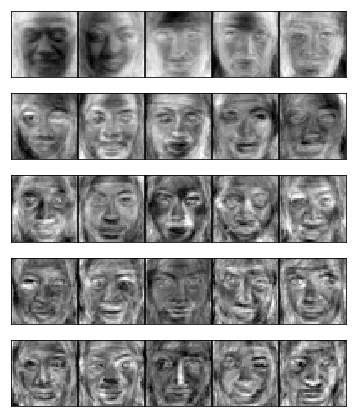

In [37]:
# Reconstruction
from math import exp
from numpy import linalg as LA

eigenValues, eigenVectors = np.linalg.eig(T_trans_T)

idx = eigenValues.argsort()[::-1]   
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:,idx]

k = 25
eigenValues = eigenValues[:k]
eigenVectors = eigenVectors[:, 0:k]

# get real eigen vector(eigen faces)
A = diff_imgs
eigenVectors = np.matmul(A, eigenVectors)
eigen_faces = np.copy(eigenVectors)

plt.figure(figsize=(6, 7.5))
n_row = int(k**(1/2))
n_col = int(k**(1/2))
for i in range(k):
    eigen_faces[:, i] =  eigenVectors[:,i] / np.linalg.norm(eigenVectors[:,i])
eigen_faces = eigen_faces.T
for i in range(k):
    face = vec2img(eigen_faces[i])
    plt.subplot(n_row ,n_col, i+1)
    plt.imshow(face, cmap = 'gray'), plt.xticks([]) , plt.yticks([])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.05)
plt.show()

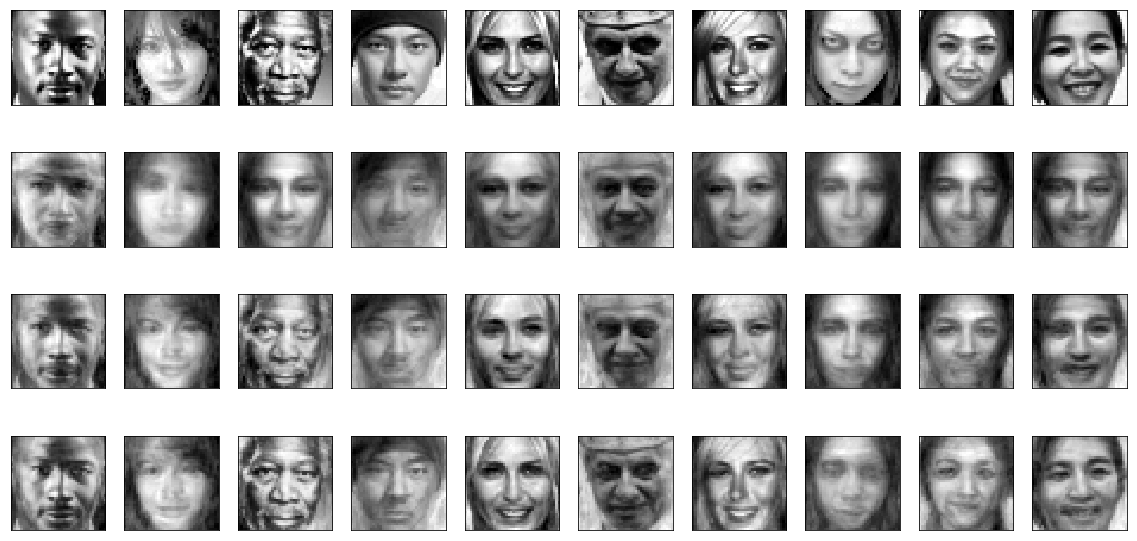

In [40]:
plt.figure(figsize=(20, 10))
id_list = [2,3,7,11,12,16, 27,36, 28, 29]
img = cv2.imread("facesP1.bmp", 0)
imgs = split_img(img)

for img_cnt in range(10):
    img = imgs[id_list[img_cnt]]
    plt.subplot(4, 10, 1+img_cnt)
    
    plt.imshow(img, cmap='gray'), plt.xticks([]) , plt.yticks([])
    
    img_vec = img2vec(img)
    diff_vec = img_vec - mean_vector
    diff_face = vec2img(diff_vec)
    #plt.imshow(diff_face, cmap='gray'), plt.xticks([]) , plt.yticks([])
    weights = []
    for i in range(k):
        weights.append(np.dot(diff_vec, eigen_faces[i]))
    reconstruct_vec = np.zeros(mean_vector.shape)
    
    for i in range(k):
        reconstruct_vec = reconstruct_vec + weights[i] * eigen_faces[i]
        reconstruct_face = vec2img(reconstruct_vec+mean_vector)
        
        if i+1 == 5:
            plt.subplot(4, 10, 11+img_cnt)
            plt.imshow(reconstruct_face, cmap='gray'), plt.xticks([]) , plt.yticks([])
            
        if i+1 == 15:
            plt.subplot(4, 10, 21+img_cnt)
            plt.imshow(reconstruct_face, cmap='gray'), plt.xticks([]) , plt.yticks([])
        if i+1 == k:
            plt.subplot(4, 10, 31+img_cnt)
            plt.imshow(reconstruct_face, cmap='gray'), plt.xticks([]) , plt.yticks([])
plt.show()

# EigenFace Class

In [3]:
def vec2img(vec, img_size=(40, 40)):
    return vec.reshape(img_size)

def img2vec(img):
    return img.reshape((prod(img.shape)))

In [4]:
def horizontally_flipped(img):
    img_flip = np.flip(img, axis=1)
    return img_flip

In [33]:
def split_img(img, img_size=(40, 40), flip=True):
    imgs = []
    n_rows, n_cols = img.shape[0], img.shape[1]
    img_height = img_size[0]
    img_width = img_size[1]
    ys = []
    for row in range(img_height, n_rows+1, img_height):
        user_id = 0
        for col in range(img_width, n_cols+1, img_width):
            row_last = row - img_height
            col_last = col - img_width
            img_crop = img[row_last:row, col_last:col]
            imgs.append(img_crop)
            ys.append(user_id)
            if flip:
                imgs.append(horizontally_flipped(img_crop))
                ys.append(user_id)
            user_id += 1
    return np.array(imgs), np.array(ys)

In [34]:
def weight_distance(w1, w2):
    w1 = np.array(w1)
    w2 = np.array(w2)
    diff = w1 - w2
    return np.dot(diff, diff)

In [90]:
class EigenFace:
    def __init__(self):
        pass
    
    def fit(self, X, y, k=25):
        self.X = X # (num_data, vec_len)
        self.y = y # (num_data, )
        N, D = X.shape[0], X.shape[1]
        imgs_vec = X.T
        # Find mean vector
        mean_vector = X.mean(0).T
        self.mean_vector = mean_vector
        # plt.imshow(vec2img(mean_vector), cmap='gray'), plt.show() # Mean Face
        
        diff_imgs = imgs_vec - np.tile(np.array([mean_vector]).T, (1, N))
        T_trans_T = np.cov(diff_imgs.T)
        
        eigenValues, eigenVectors = np.linalg.eig(T_trans_T)
        idx = eigenValues.argsort()[::-1]   
        eigenValues = eigenValues[idx]
        eigenVectors = eigenVectors[:,idx]
        # First K eigenvector
        eigenValues = eigenValues[:k]
        eigenVectors = eigenVectors[:, 0:k]
        
        # Get EigenFace
        A = diff_imgs
        eigenVectors = np.matmul(A, eigenVectors)
        eigen_faces_vec = np.copy(eigenVectors)
        
        for i in range(k):
            eigen_faces_vec[:, i] =  eigenVectors[:,i] / np.linalg.norm(eigenVectors[:,i])
            
        eigen_faces_vec = eigen_faces_vec.T  # (K, vec_length)
        self.eigen_faces_vec = eigen_faces_vec
    
    def show_eigen_face(self):
        k = self.eigen_faces_vec.shape[0]
        plt.figure(figsize=(6, 7.5))
        n_row = int(k**(1/2))
        n_col = int(k**(1/2))
        for i in range(k):
            face = vec2img(self.eigen_faces_vec[i])
            plt.subplot(n_row ,n_col, i+1)
            plt.imshow(face, cmap = 'gray'), plt.xticks([]) , plt.yticks([])
            
    def reconstruction(self, img):
        k = self.eigen_faces_vec.shape[0]
        img_vec = img2vec(img)
        diff_vec = img_vec - self.mean_vector
        diff_face = vec2img(diff_vec)
        weights = []
        for i in range(k):
            weights.append(np.dot(diff_vec, self.eigen_faces_vec[i]))
        reconstruct_vec = np.zeros(self.mean_vector.shape)
        reconstruct_faces = []
        for i in range(k):
            reconstruct_vec = reconstruct_vec + weights[i] * self.eigen_faces_vec[i]
            reconstruct_face = vec2img(reconstruct_vec+mean_vector)
            reconstruct_faces.append(reconstruct_face)
        return reconstruct_faces
    
    def predict(self, img, n_eigenvec=10):
        img = img.copy()
        k = self.eigen_faces_vec.shape[0]
        
        # Find input weight
        img_vec = img2vec(img)
        diff_vec = img_vec - self.mean_vector
        diff_face = vec2img(diff_vec)
        input_weights = []
        for i in range(n_eigenvec):
            input_weights.append(np.dot(diff_vec, self.eigen_faces_vec[i]))
        
        best_match_img = None
        best_match_error = 1e+10
        best_y = 0
        # Compare with training data
        for x, y  in zip(self.X, self.y): # (num_data, vec_len)
            img = vec2img(x)
            img_vec = img2vec(img)
            diff_vec = img_vec - self.mean_vector
            diff_face = vec2img(diff_vec)
            target_weights = []
            for i in range(n_eigenvec):
                target_weights.append(np.dot(diff_vec, self.eigen_faces_vec[i]))
            error = weight_distance(input_weights, target_weights)
            if error < best_match_error:
                best_match_img = img.copy()
                best_match_error = error
                best_y = y
        return best_match_img, best_y

In [91]:
import matplotlib.pyplot as plt
from numpy import prod
import pandas as pd
import numpy as np
import cv2
# Read Data
img = cv2.imread("data/facesP1.bmp", 0)
imgs, y = split_img(img, flip=True)
X = imgs.reshape( (prod(imgs.shape[:1]), prod(imgs.shape[1:])) )
print(X.shape)
print(y.shape)

(160, 1600)
(160,)


In [92]:
X_train, y_train = X[:-32], y[:-32]
X_test, y_test = X[-32:], y[-32:]

In [93]:
print(y_train)
print(y_test)

[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11
 12 12 13 13 14 14 15 15  0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7
  8  8  9  9 10 10 11 11 12 12 13 13 14 14 15 15  0  0  1  1  2  2  3  3
  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11 12 12 13 13 14 14 15 15
  0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11
 12 12 13 13 14 14 15 15]
[ 0  0  1  1  2  2  3  3  4  4  5  5  6  6  7  7  8  8  9  9 10 10 11 11
 12 12 13 13 14 14 15 15]


In [1]:
# Fit data
eigenface = EigenFace()
eigenface.fit(X_train, y_train, k=100)
# eigenface.show_eigen_face()

NameError: name 'EigenFace' is not defined

10 10


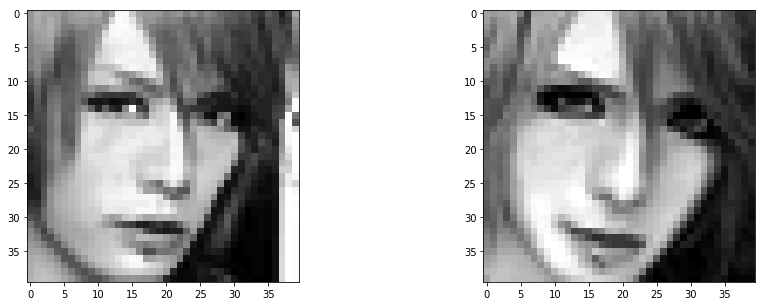

In [96]:
# Predict
img, label = vec2img(X_test[20]), y_test[20]
img_predict, y_pred = eigenface.predict(img, n_eigenvec=25)
print(label, y_pred)
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1), plt.imshow(img, cmap='gray')
plt.subplot(1, 2, 2), plt.imshow(img_predict, cmap='gray')
plt.show()

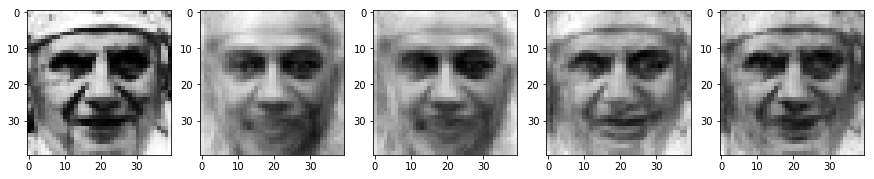

In [66]:
# Reconstruction
img = cv2.imread("data/facesP1.bmp", 0)
imgs = split_img(img)
img = imgs[1]
reconstruct_faces = eigenface.reconstruction(img)

plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1), plt.imshow(img, cmap='gray')
plt.subplot(1, 5, 2), plt.imshow(reconstruct_faces[0], cmap='gray')
plt.subplot(1, 5, 3), plt.imshow(reconstruct_faces[5], cmap='gray') 
plt.subplot(1, 5, 4), plt.imshow(reconstruct_faces[15], cmap='gray')
plt.subplot(1, 5, 5), plt.imshow(reconstruct_faces[-1], cmap='gray')
plt.show()